In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pickle

# easiest way to install tensorflow is using Anaconda

# conda create --name tf python=3.8 anaconda 
# conda activate tf
# conda install tensorflow-gpu

# this installs a pretty old TF as Anaconda doesn't maintain packages for tensorflow-gpu in a while, 
# but everything works with this older version

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import utils as np_utils
from fMRINet import fmriNet8, fmriNet16, fmriNet32

import sklearn
import tensorflow as tf

# from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.optimizers import AdamW


# needed for innvestigate.. testing things out
#import tensorflow as tf
#tf.compat.v1.disable_eager_execution()


In [2]:
# Load the DataFrame from the pickle file /-/ this is the toy dataframe ; for the actual data; please consider dataframe.pkl and get in touch with the author.


# #{'PVT': 0, 'VWM': 1, 'DOT': 2, 'MOD': 3, 'DYN': 4, 'rest': 5}
# df = pd.read_pickle('dataframe.pkl')

# df.head()


#{'PVT': 0, 'VWM': 1, 'DOT': 2, 'MOD': 3, 'DYN': 4, 'rest': 5}
df = pd.read_pickle('toy_dataframe.pkl')

df.head()

,Task,Time_Series_Data,subject,session
0,1,"[[0.6475575, -0.01364837, 0.5427136, 1.0460113...",3530o,1
1,3,"[[-0.099536106, 0.4977047, 0.85864395, -0.7931...",1853b,7
3,1,"[[1.4353832, 1.2753311, 1.0209471, 0.4113485, ...",1853b,5
4,2,"[[1.6184205, 4.448491, 4.772308, -0.48710814, ...",4558a,8
6,5,"[[-0.96789235, -0.43344012, 0.14106064, -0.685...",3288w,1


In [ ]:
# subjs = df["subject"].unique()
# np.random.shuffle(subjs) # do in-place shuffle

# to work with the same train/validation splits while doing model development
with open('subjs.pickle', 'rb') as f:
    subjs = pickle.load(f)

# pull train/valid data by taking subjects from shuffled list
train_df = df[df['subject'].isin(subjs[0:45])]
valid_df = df[df['subject'].isin(subjs[45:,])]

# convert to numpy arrays and do reordering of data dimensions to feed into network
train_label = np.array(train_df['Task'])

train_data  = np.dstack(train_df['Time_Series_Data'])
train_data  = np.expand_dims(train_data, axis=0)
train_data  = np.transpose(train_data, axes=[3, 2, 1, 0]) # (batch, row, time, region)

valid_label = np.array(valid_df['Task'])

valid_data  = np.dstack(valid_df['Time_Series_Data'])
valid_data  = np.expand_dims(valid_data, axis=0)
valid_data  = np.transpose(valid_data, axes=[3, 2, 1, 0]) # (batch, row, time, region)

In [ ]:
train_label = np_utils.to_categorical(train_label)
valid_label = np_utils.to_categorical(valid_label)


In [ ]:
# calculate class weights for training data to use at training time
train_label_v2 = np.argmax(train_label, axis=1)
a, b           = np.unique(train_label_v2, return_counts=True)
weights        = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=a, y=train_label_v2)
class_weights  = {0:weights[0], 1:weights[1], 2:weights[2], 3:weights[3], 4:weights[4], 5:weights[5]}
class_weights

{0: 1.3031135531135531,
 1: 0.8800247371675943,
 2: 1.2417102966841187,
 3: 0.9139370584457289,
 4: 0.568063872255489,
 5: 2.2914653784219}

In [3]:
model = fmriNet8(num_classes=6)  # or fmriNet16(), fmriNet32()


model.summary()

Model: "fmriNet8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 214, 277, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 214, 277, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 214, 277, 8)    │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 277, 214, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 277, 1, 32)     │         6,848 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 277, 1, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 277, 1, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_1 (Permute)             │ (None, 1, 277, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 18, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 18, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1, 18, 64)      │         2,304 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 18, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 1, 4, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         1,542 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,558 (45.15 KB)

 Trainable params: 11,366 (44.40 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=AdamW(weight_decay=0.0005), 
              metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

# simple learning rate schedule, half learning rate every 200 epochs
# which seems to do ok for this data
def lr_schedule(epoch):
         return (0.001 * np.power(0.5, np.floor(epoch/200)))

scheduler    = LearningRateScheduler(lr_schedule, verbose=1)

In [ ]:
# without eager execution this takes much longer to train..
fittedModel = model.fit(train_data, train_label, batch_size = 64, epochs = 400, 
                        verbose = 2, validation_data=(valid_data, valid_label),
                        callbacks=[checkpointer], class_weight = class_weights)

Epoch 1/400
45/45 - 3s - loss: 1.9776 - accuracy: 0.1803 - val_loss: 1.7869 - val_accuracy: 0.3099

Epoch 00001: val_loss improved from inf to 1.78688, saving model to /tmp/checkpoint.h5
Epoch 2/400
45/45 - 2s - loss: 1.8058 - accuracy: 0.2495 - val_loss: 1.7682 - val_accuracy: 0.4038

Epoch 00002: val_loss improved from 1.78688 to 1.76820, saving model to /tmp/checkpoint.h5
Epoch 3/400
45/45 - 2s - loss: 1.6262 - accuracy: 0.3282 - val_loss: 1.7133 - val_accuracy: 0.4648

Epoch 00003: val_loss improved from 1.76820 to 1.71329, saving model to /tmp/checkpoint.h5
Epoch 4/400
45/45 - 2s - loss: 1.5147 - accuracy: 0.3735 - val_loss: 1.6539 - val_accuracy: 0.4241

Epoch 00004: val_loss improved from 1.71329 to 1.65388, saving model to /tmp/checkpoint.h5
Epoch 5/400
45/45 - 2s - loss: 1.4414 - accuracy: 0.3855 - val_loss: 1.5728 - val_accuracy: 0.4930

Epoch 00005: val_loss improved from 1.65388 to 1.57280, saving model to /tmp/checkpoint.h5
Epoch 6/400
45/45 - 2s - loss: 1.3795 - accuracy:

KeyboardInterrupt: 

In [ ]:
model.load_weights('/tmp/checkpoint.h5')
preds = model.predict(valid_data)

In [ ]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(np.argmax(valid_label, axis=1), np.argmax(preds, axis=1))

0.8409298089380891

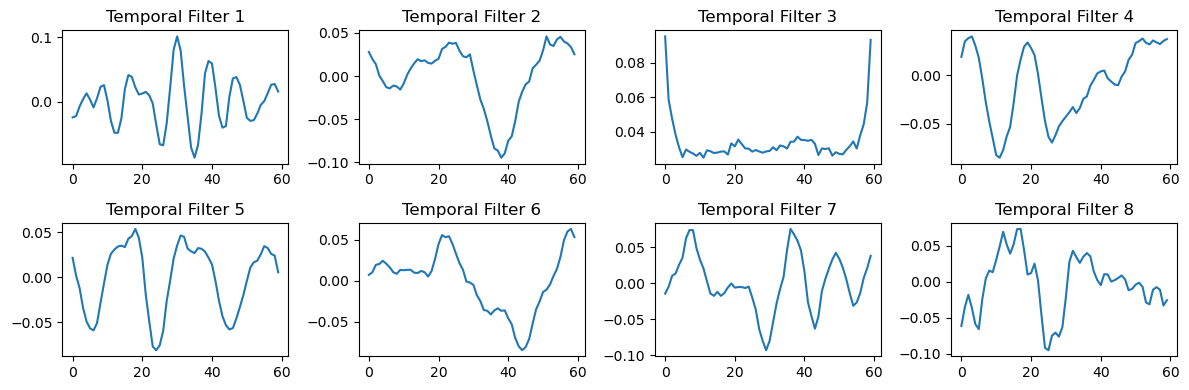

In [ ]:
filters = np.squeeze(model.layers[2].get_weights())

fig = plt.subplots(2, 4, figsize=(12, 4))

for i in range(1, 9):
    plt.subplot(2, 4, i)
    plt.plot(filters[:, i-1])
    plt.title(f'Temporal Filter {i}')
    
plt.tight_layout()

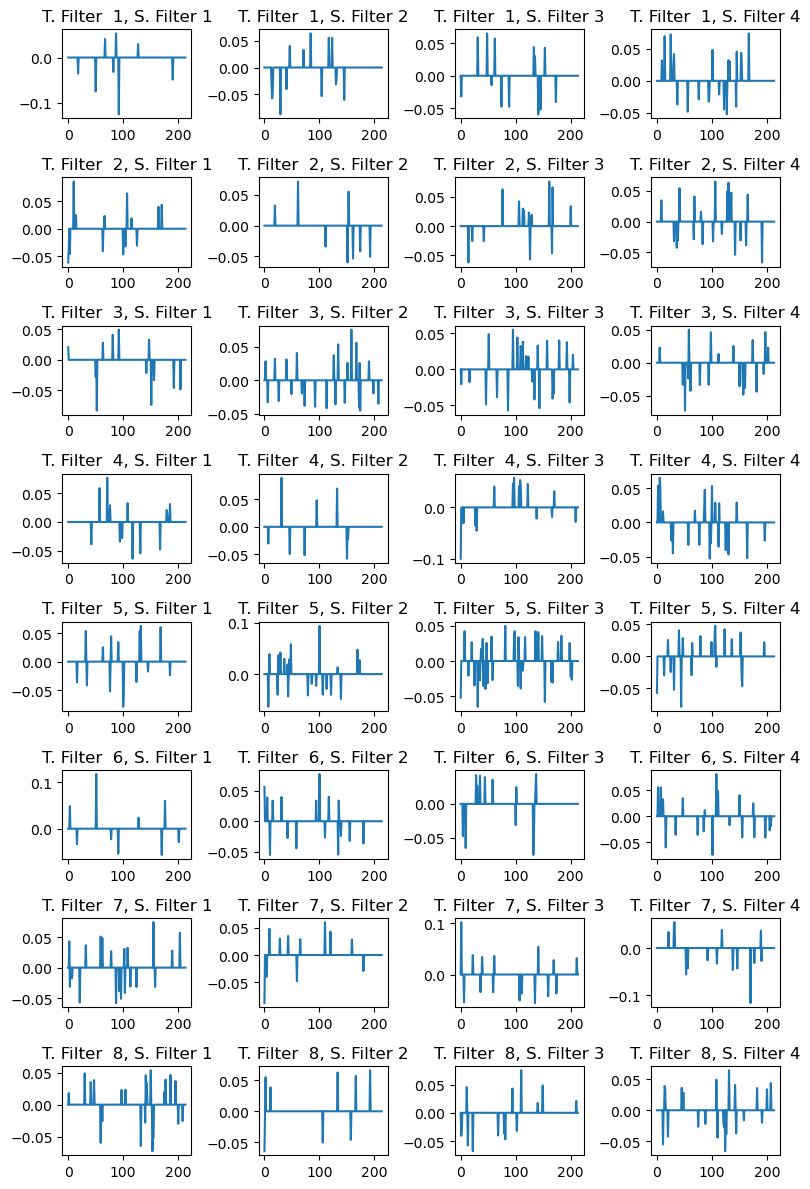

In [ ]:
filters = np.squeeze(model.layers[4].get_weights())

fig = plt.subplots(8, 4, figsize=(8, 12))

i = 1
for j in range(8):
    for k in range(4):
        plt.subplot(8, 4, i)
        plt.plot(filters[:, j, k])
        plt.title(f'T. Filter  {j+1}, S. Filter {k+1}')
        i = i + 1
    
plt.tight_layout()